# Accessing data from PODAAC
The NASA data center for physical oceanography (PO.DAAC) has migrated most of their data and services to the cloud.  This notebook runs through a quick example of access these data via OPeNDAP.  For more tutorials see their GitHub at https://github.com/podaac/tutorials/blob/master/notebooks/

The notebook will:
 * Search the common metadata repository (CMR) for the MUR dataset
 * Obtain OPeNDAP links from CMR search
 * Download data from OPeNDAP links and open via xarray to visualize data



In [1]:
# load needed packages
from netCDF4 import Dataset
import xarray as xr
import dask
import os
import requests
import earthaccess

#Allows us to visualize the dask progress for parallel operations
from dask.diagnostics import ProgressBar
ProgressBar().register()

### Earthdata Login

An Earthdata Login account is required to access data, as well as discover restricted data, from the NASA Earthdata system. Thus, to access NASA data, you need Earthdata Login. If you don't already have one, please visit https://urs.earthdata.nasa.gov to register and manage your Earthdata Login account. This account is free to create and only takes a moment to set up. We use `earthaccess` to authenticate your login credentials below.

In [2]:
auth = earthaccess.login()

### Request link for OPeNDAP

In [3]:
#CMR Link to use
#https://cmr.earthdata.nasa.gov/search/granules.umm_json?collection_concept_id=C1625128926-GHRC_CLOUD&temporal=2019-01-01T10:00:00Z,2019-12-31T23:59:59Z
r = requests.get('https://cmr.earthdata.nasa.gov/search/granules.umm_json?collection_concept_id=C1996881146-POCLOUD&temporal=2019-01-01T10:00:00Z,2019-02-01T00:00:00Z&pageSize=365')
response_body = r.json()

In [4]:
od_files = []
for itm in response_body['items']:
    for urls in itm['umm']['RelatedUrls']:
        if 'OPeNDAP' in urls['Description']:
            od_files.append(urls['URL'])

od_files
        

['https://opendap.earthdata.nasa.gov/providers/POCLOUD/collections/GHRSST%20Level%204%20MUR%20Global%20Foundation%20Sea%20Surface%20Temperature%20Analysis%20(v4.1)/granules/20190101090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1',
 'https://opendap.earthdata.nasa.gov/providers/POCLOUD/collections/GHRSST%20Level%204%20MUR%20Global%20Foundation%20Sea%20Surface%20Temperature%20Analysis%20(v4.1)/granules/20190102090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1',
 'https://opendap.earthdata.nasa.gov/providers/POCLOUD/collections/GHRSST%20Level%204%20MUR%20Global%20Foundation%20Sea%20Surface%20Temperature%20Analysis%20(v4.1)/granules/20190103090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1',
 'https://opendap.earthdata.nasa.gov/providers/POCLOUD/collections/GHRSST%20Level%204%20MUR%20Global%20Foundation%20Sea%20Surface%20Temperature%20Analysis%20(v4.1)/granules/20190104090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1',
 'https://opendap.earthdata.nasa.gov/providers/POCLOUD/collections/G

In [5]:
len(od_files)

32

In [7]:
for f in od_files:
    print (" opening " + f)
    data_url = f'{f}.dap.nc4'
    
    
    # The notation below is [start index, step, end index]
    # lat[ /lat= 0..17998] start index. = -90
    # lon[ /lon= 0..35999] start index. = -180
    # time[ /time= 0..0] 
    required_variables = {'analysed_sst[0:1:0][000:1:9000][000:1:9000]',
                          'analysis_error[0:1:0][000:1:9000][000:1:9000]',
                          'lat[000:1:9000]',
                          'lon[000:1:9000]',
                         'time[0:1:0]'}

    #upper latitude, left longitude, lower latitude, right longitude

    basename = os.path.basename(data_url)
    request_params = {'dap4.ce': ';'.join(required_variables)}
    #identity encoding to work around an issue with server side response compression (??)
    response = requests.get(data_url, params=request_params,  headers={'Accept-Encoding': 'identity'})

    if response.ok:
        with open(basename, 'wb') as file_handler:
            file_handler.write(response.content)
    else:
        print(f'Request failed: {response.text}')



 opening https://opendap.earthdata.nasa.gov/providers/POCLOUD/collections/GHRSST%20Level%204%20MUR%20Global%20Foundation%20Sea%20Surface%20Temperature%20Analysis%20(v4.1)/granules/20190101090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1
 opening https://opendap.earthdata.nasa.gov/providers/POCLOUD/collections/GHRSST%20Level%204%20MUR%20Global%20Foundation%20Sea%20Surface%20Temperature%20Analysis%20(v4.1)/granules/20190102090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1
 opening https://opendap.earthdata.nasa.gov/providers/POCLOUD/collections/GHRSST%20Level%204%20MUR%20Global%20Foundation%20Sea%20Surface%20Temperature%20Analysis%20(v4.1)/granules/20190103090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1
 opening https://opendap.earthdata.nasa.gov/providers/POCLOUD/collections/GHRSST%20Level%204%20MUR%20Global%20Foundation%20Sea%20Surface%20Temperature%20Analysis%20(v4.1)/granules/20190104090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1
 opening https://opendap.earthdata.nasa.gov/prov

In [8]:
import xarray as xr
cloud_data = xr.open_mfdataset('*.dap.nc4', engine='netcdf4')

In [9]:
cloud_data

<xarray.Dataset> Size: 41GB
Dimensions:         (time: 32, lat: 9001, lon: 9001)
Coordinates:
  * time            (time) datetime64[ns] 256B 2019-01-01T09:00:00 ... 2019-0...
  * lat             (lat) float32 36kB -89.99 -89.98 -89.97 ... -0.01 0.0 0.01
  * lon             (lon) float32 36kB -180.0 -180.0 -180.0 ... -90.0 -89.99
Data variables:
    analysed_sst    (time, lat, lon) float64 21GB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    analysis_error  (time, lat, lon) float64 21GB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
Attributes: (12/53)
    Conventions:                         CF-1.5
    title:                               Daily MUR SST, Final product
    summary:                             A merged, multi-sensor L4 Foundation...
    references:                          http://podaac.jpl.nasa.gov/Multi-sca...
    institution:                         Jet Propulsion Laboratory
    history:                             created at nominal 4-day latency; re...
    ...                                  ...
    build_dmrpp_metadata.build_dmrpp:    3.20.13-664
    build_dmrpp_metadata.bes:            3.20.13-664
    build_dmrpp_metadata.libdap:         libdap-3.20.11-198
    build_dmrpp_metadata.configuration:  \n# TheBESKeys::get_as_config()\nAll...
    build_dmrpp_metadata.invocation:     build_dmrpp -c /tmp/bes_conf_zPqx -f...
    history_json:                        [{"$schema":"https:\/\/harmony.earth...

[########################################] | 100% Completed | 17.93 s


(array([3.66360932e+08, 1.41839843e+08, 1.33124088e+08, 1.42820817e+08,
        1.34985851e+08, 1.21022644e+08, 1.70274605e+08, 3.11520620e+08,
        4.31977734e+08, 2.16985858e+08]),
 array([271.35  , 274.6785, 278.007 , 281.3355, 284.664 , 287.9925,
        291.321 , 294.6495, 297.978 , 301.3065, 304.635 ]),
 <BarContainer object of 10 artists>)

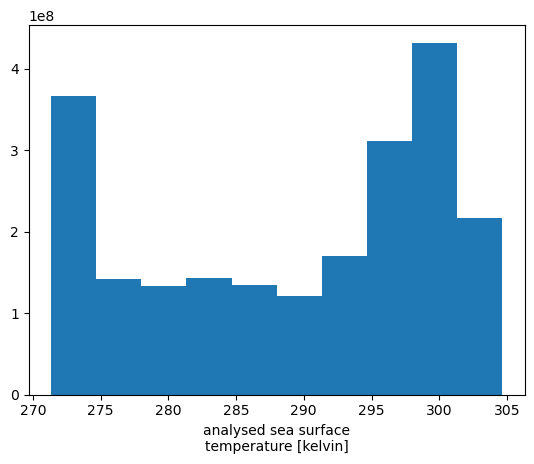

In [12]:
#Histogram
cloud_data['analysed_sst'].plot()


[########################################] | 100% Completed | 523.20 ms


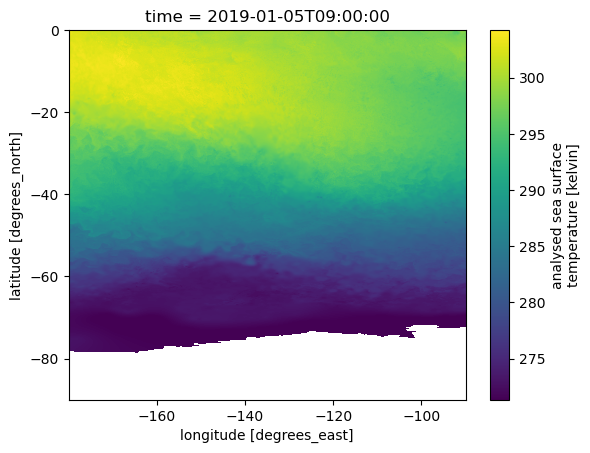

In [13]:
# Choose one time segment, plot the data
cloud_data['analysed_sst'].isel(time=4).plot()


[########################################] | 100% Completed | 202.35 ms


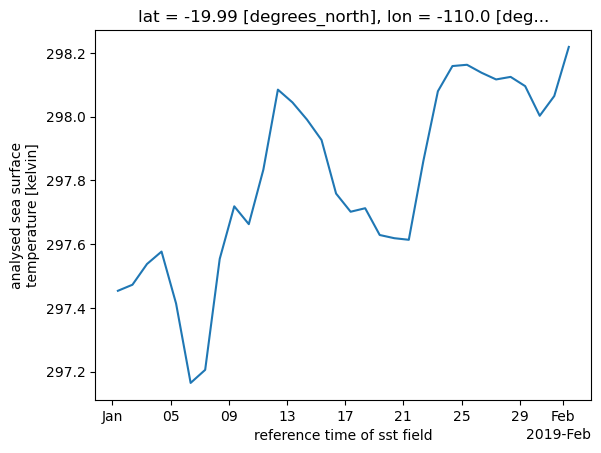

In [14]:
#Plot a single point over time
cloud_data['analysed_sst'].isel(lat=7000, lon=7000).plot()
